<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/deepseek_janus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Mon Feb  3 14:39:39 2025
Driver Version                            : 550.54.15
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:00:03.0
    Product Name                          : NVIDIA L4
    Product Brand                         : NVIDIA
    Product Architecture                  : Ada Lovelace
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number          

# init

In [ ]:
!git clone https://github.com/deepseek-ai/Janus.git

In [1]:
%cd /content/Janus

/content/Janus


In [ ]:
!pip install -q -e .

In [ ]:
# https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2
# https://github.com/Dao-AILab/flash-attention

!pip install -q flash-attn --no-build-isolation

In [6]:
!pip install -q imageio[ffmpeg] matplotlib

# download ckpt

In [7]:
from google.colab import userdata
HF_TOKEN=userdata.get('HF_TOKEN')

In [ ]:
!huggingface-cli login --token $HF_TOKEN --add-to-git-credential

In [ ]:
!huggingface-cli download deepseek-ai/Janus-1.3B --quiet --local-dir models/deepseek-ai/Janus-1.3B

In [ ]:
!huggingface-cli download stabilityai/sdxl-vae --quiet --local-dir models/stabilityai/sdxl-vae

In [ ]:
!huggingface-cli download deepseek-ai/JanusFlow-1.3B --quiet --local-dir models/deepseek-ai/JanusFlow-1.3B

In [2]:
!huggingface-cli download deepseek-ai/Janus-Pro-1B --quiet --local-dir models/deepseek-ai/Janus-Pro-1B

/content/Janus/models/deepseek-ai/Janus-Pro-1B


In [9]:
!huggingface-cli download deepseek-ai/Janus-Pro-7B --quiet --local-dir models/deepseek-ai/Janus-Pro-7B

/content/Janus/models/deepseek-ai/Janus-Pro-7B


# Janus

In [ ]:
from IPython.display import Image
Image(filename='images/equation.png')

In [ ]:
## Multimodal Understanding

import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "models/deepseek-ai/Janus-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    #torch_dtype=torch.bfloat16,
    #attn_implementation="eager"
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>\nConvert the formula into latex code.",
        "images": ["images/equation.png"],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


In [ ]:
## Text-to-Image Generation
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "models/deepseek-ai/Janus-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "Assistant", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)
        print(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

In [ ]:
from IPython.display import Image
Image(filename='generated_samples/img_0.jpg')

['generated_samples/img_0.jpg', 'generated_samples/img_1.jpg', 'generated_samples/img_10.jpg', 'generated_samples/img_11.jpg', 'generated_samples/img_12.jpg', 'generated_samples/img_13.jpg', 'generated_samples/img_14.jpg', 'generated_samples/img_15.jpg', 'generated_samples/img_2.jpg', 'generated_samples/img_3.jpg', 'generated_samples/img_4.jpg', 'generated_samples/img_5.jpg', 'generated_samples/img_6.jpg', 'generated_samples/img_7.jpg', 'generated_samples/img_8.jpg', 'generated_samples/img_9.jpg']


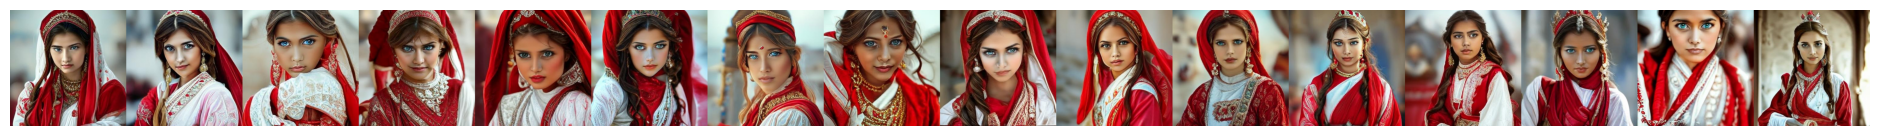

In [6]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import glob
import numpy as np

filenames = sorted(glob.glob('generated_samples/img_*.jpg'))
print(filenames)
images = [iio.imread(filename) for filename in filenames]
# 水平合并图像
merged_image = np.concatenate(images, axis=1)

# 如果需要垂直合并，可以使用 axis=0
# merged_image = np.concatenate(images, axis=0)

plt.figure(figsize=(24, 24))  # 调整图像大小以适应所有图像
plt.imshow(merged_image)
plt.axis('off')  # 隐藏坐标轴
plt.show()

# JanusFlow

In [ ]:
##Multimodal Understanding

import torch
from janus.janusflow.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "models/deepseek-ai/JanusFlow-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt = MultiModalityCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>\nConvert the formula into latex code.",
        "images": ["images/equation.png"],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


In [ ]:
## Text-to-Image Generation
import os
import PIL.Image
import torch
import numpy as np
from janus.janusflow.models import MultiModalityCausalLM, VLChatProcessor
import torchvision


# specify the path to the model
model_path = "models/deepseek-ai/JanusFlow-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt = MultiModalityCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

from diffusers.models import AutoencoderKL
# remember to use bfloat16 dtype, this vae doesn't work with fp16
vae = AutoencoderKL.from_pretrained("models/stabilityai/sdxl-vae")
vae = vae.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "Assistant", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_gen_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    cfg_weight: float = 5.0,
    num_inference_steps: int = 30,
    batchsize: int = 5
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.stack([input_ids] * 2 * batchsize).cuda()
    tokens[batchsize:, 1:] = vl_chat_processor.pad_id
    inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)

    # we remove the last <bog> token and replace it with t_emb later
    inputs_embeds = inputs_embeds[:, :-1, :]

    # generate with rectified flow ode
    # step 1: encode with vision_gen_enc
    z = torch.randn((batchsize, 4, 48, 48), dtype=torch.bfloat16).cuda()

    dt = 1.0 / num_inference_steps
    dt = torch.zeros_like(z).cuda().to(torch.bfloat16) + dt

    # step 2: run ode
    attention_mask = torch.ones((2*batchsize, inputs_embeds.shape[1]+577)).to(vl_gpt.device)
    attention_mask[batchsize:, 1:inputs_embeds.shape[1]] = 0
    attention_mask = attention_mask.int()
    for step in range(num_inference_steps):
        # prepare inputs for the llm
        z_input = torch.cat([z, z], dim=0) # for cfg
        t = step / num_inference_steps * 1000.
        t = torch.tensor([t] * z_input.shape[0]).to(dt)
        z_enc = vl_gpt.vision_gen_enc_model(z_input, t)
        z_emb, t_emb, hs = z_enc[0], z_enc[1], z_enc[2]
        z_emb = z_emb.view(z_emb.shape[0], z_emb.shape[1], -1).permute(0, 2, 1)
        z_emb = vl_gpt.vision_gen_enc_aligner(z_emb)
        llm_emb = torch.cat([inputs_embeds, t_emb.unsqueeze(1), z_emb], dim=1)

        # input to the llm
        # we apply attention mask for CFG: 1 for tokens that are not masked, 0 for tokens that are masked.
        if step == 0:
            outputs = vl_gpt.language_model.model(inputs_embeds=llm_emb,
                                             use_cache=True,
                                             attention_mask=attention_mask,
                                             past_key_values=None)
            past_key_values = []
            for kv_cache in past_key_values:
                k, v = kv_cache[0], kv_cache[1]
                past_key_values.append((k[:, :, :inputs_embeds.shape[1], :], v[:, :, :inputs_embeds.shape[1], :]))
            past_key_values = tuple(past_key_values)
        else:
            outputs = vl_gpt.language_model.model(inputs_embeds=llm_emb,
                                             use_cache=True,
                                             attention_mask=attention_mask,
                                             past_key_values=past_key_values)
        hidden_states = outputs.last_hidden_state

        # transform hidden_states back to v
        hidden_states = vl_gpt.vision_gen_dec_aligner(vl_gpt.vision_gen_dec_aligner_norm(hidden_states[:, -576:, :]))
        hidden_states = hidden_states.reshape(z_emb.shape[0], 24, 24, 768).permute(0, 3, 1, 2)
        v = vl_gpt.vision_gen_dec_model(hidden_states, hs, t_emb)
        v_cond, v_uncond = torch.chunk(v, 2)
        v = cfg_weight * v_cond - (cfg_weight-1.) * v_uncond
        z = z + dt * v

    # step 3: decode with vision_gen_dec and sdxl vae
    decoded_image = vae.decode(z / vae.config.scaling_factor).sample

    os.makedirs('generated_samples', exist_ok=True)
    save_path = os.path.join('generated_samples', "img.jpg")
    torchvision.utils.save_image(decoded_image.clip_(-1.0, 1.0)*0.5+0.5, save_path)

generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    cfg_weight=2.0,
    num_inference_steps=30,
    batchsize=5
)

In [ ]:
from IPython.display import Image
Image(filename='generated_samples/img.jpg')

# Janus-Pro

In [2]:
question="Convert the formula into latex code."
image="images/equation.png"
model_path = "models/deepseek-ai/Janus-Pro-1B"
#model_path = "models/deepseek-ai/Janus-Pro-7B"

In [3]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()


Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: mask_prompt, num_image_tokens, ignore_id, sft_format, image_tag, add_special_tok

## Multimodal Understanding


In [5]:
conversation = [
    {
        "role": "User",
        "content": f"<image_placeholder>\n{question}",
        "images": [image],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
conversation1 = [
    {
        "role": "User",
        "content": f"<image_placeholder>\n{question}",
        #"images": [image],
    },
    {"role": "Assistant", "content": ""},
]
prepare_inputs = vl_chat_processor(
    conversations=conversation1, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>
Convert the formula into latex code.

Assistant: 

\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}

The LaTeX code for the given formula is:

\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}


## Multimodal Understanding with PIL.Image


In [6]:
from transformers import TextIteratorStreamer
from PIL import Image

conversation = []
message = {
        "role": "User",
        "content": f"<image_placeholder>\n{question}",
        #"images": [image],
        }

# load images and prepare for inputs
conversation.append(message)
conversation.append({"role": "Assistant", "content": ""})
pil_images = [Image.open(image)]
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)



You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>
Convert the formula into latex code.

Assistant: 

\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}

The LaTeX code for the given formula is:

\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}


## Multimodal Understanding with streamer


In [7]:
from transformers import TextIteratorStreamer
from PIL import Image
from threading import Thread

streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

conversation = []
message = {
        "role": "User",
        "content": f"<image_placeholder>\n{question}",
        #"images": [image],
        }

# load images and prepare for inputs
conversation.append(message)
conversation.append({"role": "Assistant", "content": ""})
pil_images = [Image.open(image)]
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

## run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

## run the model to get the response
generation_kwargs = dict(
    inputs_embeds=inputs_embeds,
    streamer=streamer,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)
thread = Thread(target=vl_gpt.language_model.generate, kwargs=generation_kwargs)
thread.start()

generated_text = ""
for new_text in streamer:
    print(new_text,end='',flush=True)
    generated_text += new_text

#print(generated_text)




\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}

The LaTeX code for the given formula is:

\begin{equation}
A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^{n} \begin{bmatrix} 4 & \\ 9 & \end{bmatrix} \end{bmatrix}
\end{equation}

## Text-to-Image Generation


In [4]:
import os
import PIL
import numpy as np

conversation = [
    {
        "role": "User",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "Assistant", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "pro_img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


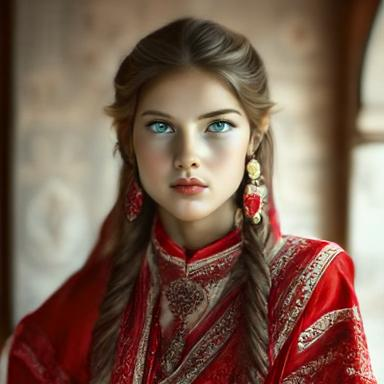

In [5]:
from IPython.display import Image
Image(filename='generated_samples/pro_img_1.jpg')

['generated_samples/pro_img_0.jpg', 'generated_samples/pro_img_1.jpg', 'generated_samples/pro_img_10.jpg', 'generated_samples/pro_img_11.jpg', 'generated_samples/pro_img_12.jpg', 'generated_samples/pro_img_13.jpg', 'generated_samples/pro_img_14.jpg', 'generated_samples/pro_img_15.jpg', 'generated_samples/pro_img_2.jpg', 'generated_samples/pro_img_3.jpg', 'generated_samples/pro_img_4.jpg', 'generated_samples/pro_img_5.jpg', 'generated_samples/pro_img_6.jpg', 'generated_samples/pro_img_7.jpg', 'generated_samples/pro_img_8.jpg', 'generated_samples/pro_img_9.jpg']


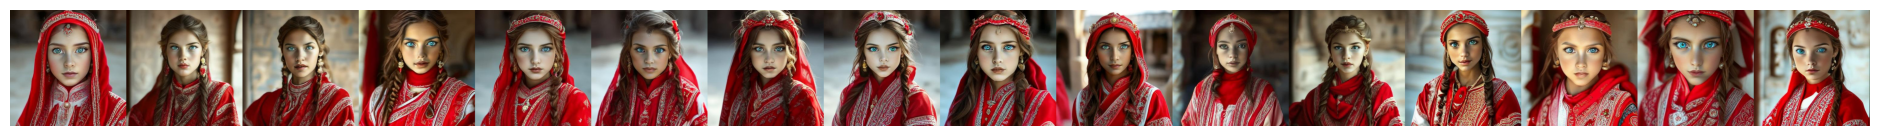

In [6]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import glob
import numpy as np

filenames = sorted(glob.glob('generated_samples/pro_img_*.jpg'))
print(filenames)
images = [iio.imread(filename) for filename in filenames]
# 水平合并图像
merged_image = np.concatenate(images, axis=1)

# 如果需要垂直合并，可以使用 axis=0
# merged_image = np.concatenate(images, axis=0)

plt.figure(figsize=(24, 24))  # 调整图像大小以适应所有图像
plt.imshow(merged_image)
plt.axis('off')  # 隐藏坐标轴
plt.show()